In [1]:
import pandas as pd
import warnings
import yfinance as yf
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('seaborn-darkgrid')
warnings.filterwarnings("ignore")


data = pd.read_html('https://en.wikipedia.org/wiki/List_of_S%26P_500_companies', header=0)

stocks = pd.DataFrame(data[0])


In [2]:
stocks.Symbol = stocks.Symbol.str.replace(".", "-")
stocks.set_index('Symbol', inplace=True, drop=True)
stock_prices = yf.download(list(stocks.index), '2022-1-1', auto_adjust=True, group_by='Symbol')


[*********************100%***********************]  503 of 503 completed


In [3]:
stock_prices.columns.levels

stock_prices = stock_prices.drop(['Open', 'High', 'Low', 'Volume'], level=1, axis=1)
stock_prices.tail()

,AMZN,ULTA,WRK,IPG,STZ,SIVB,EL,MTB,ITW,GNRC,...,GIS,UNH,PPL,K,CTRA,PNW,CNP,KEY,PGR,WY
,Close,Close,Close,Close,Close,Close,Close,Close,Close,Close,...,Close,Close,Close,Close,Close,Close,Close,Close,Close,Close
Date,,,,,,,,,,,,,,,,,,,,,
2022-12-07,88.459999,480.049988,35.939999,32.099998,246.660004,208.279999,232.529999,147.970001,220.100006,90.739998,...,87.220001,542.909973,28.980000,73.889999,25.480000,77.620003,30.389999,17.260000,130.479996,31.690001
2022-12-08,90.349998,481.649994,36.000000,32.150002,246.380005,222.639999,242.619995,150.119995,221.320007,92.709999,...,87.550003,547.919983,29.059999,73.459999,24.950001,77.779999,30.350000,17.180000,131.179993,31.670000
2022-12-09,89.089996,471.630005,35.880001,32.070000,242.039993,220.270004,240.410004,151.380005,219.759995,92.669998,...,85.839996,539.200012,28.950001,72.339996,24.480000,77.500000,30.450001,17.420000,129.380005,31.480000
2022-12-12,90.550003,471.959991,36.650002,32.860001,245.490005,223.399994,244.440002,151.539993,224.250000,96.000000,...,86.839996,545.859985,29.450001,74.040001,24.850000,79.010002,31.010000,17.559999,129.940002,32.320000
2022-12-13,NaN,467.140015,37.264999,33.360001,244.089996,232.259995,248.255005,146.500000,226.289993,100.057899,...,87.059998,536.109985,29.295000,73.540001,25.160000,79.290001,30.780001,17.219999,129.460007,NaN


In [4]:
# Calculate top volatility decile

stock_prices.index = pd.to_datetime(stock_prices.index)

In [5]:
price_pct_change = stock_prices.pct_change()
price_pct_change.columns

MultiIndex([('AMZN', 'Close'),
            ('ULTA', 'Close'),
            ( 'WRK', 'Close'),
            ( 'IPG', 'Close'),
            ( 'STZ', 'Close'),
            ('SIVB', 'Close'),
            (  'EL', 'Close'),
            ( 'MTB', 'Close'),
            ( 'ITW', 'Close'),
            ('GNRC', 'Close'),
            ...
            ( 'GIS', 'Close'),
            ( 'UNH', 'Close'),
            ( 'PPL', 'Close'),
            (   'K', 'Close'),
            ('CTRA', 'Close'),
            ( 'PNW', 'Close'),
            ( 'CNP', 'Close'),
            ( 'KEY', 'Close'),
            ( 'PGR', 'Close'),
            (  'WY', 'Close')],
           length=503)

In [6]:
# calculate standard deviation
stock_std = price_pct_change.std()
stock_std.axes

[MultiIndex([('AMZN', 'Close'),
             ('ULTA', 'Close'),
             ( 'WRK', 'Close'),
             ( 'IPG', 'Close'),
             ( 'STZ', 'Close'),
             ('SIVB', 'Close'),
             (  'EL', 'Close'),
             ( 'MTB', 'Close'),
             ( 'ITW', 'Close'),
             ('GNRC', 'Close'),
             ...
             ( 'GIS', 'Close'),
             ( 'UNH', 'Close'),
             ( 'PPL', 'Close'),
             (   'K', 'Close'),
             ('CTRA', 'Close'),
             ( 'PNW', 'Close'),
             ( 'CNP', 'Close'),
             ( 'KEY', 'Close'),
             ( 'PGR', 'Close'),
             (  'WY', 'Close')],
            length=503)]

50


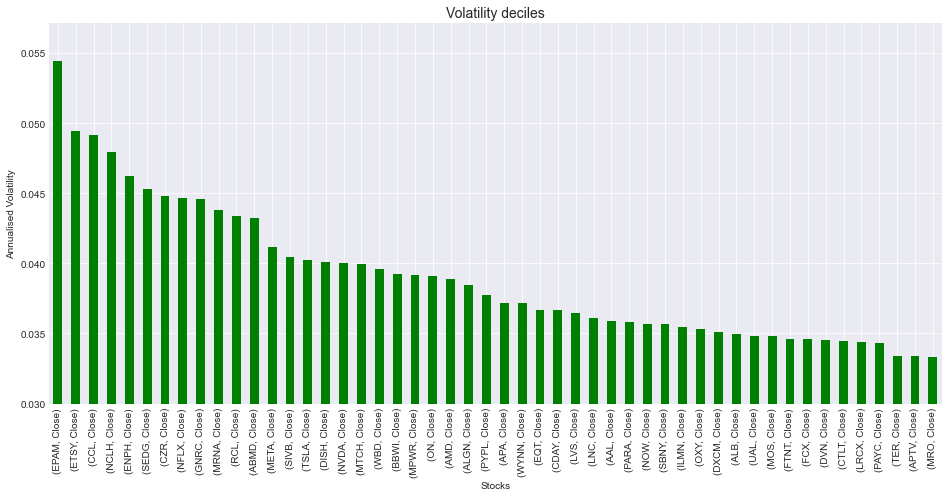

In [7]:
volatility_sort = stock_std.sort_values(ascending=False)
volatility_sort
topdecile = volatility_sort[:int(len(stock_std)*0.1)]
print(topdecile.count())
topdecile.plot.bar(figsize=(16,7),color='green',ylim=topdecile.min()*0.9)
plt.title('Volatility deciles', fontsize=14)
plt.xlabel('Stocks')
plt.ylabel('Annualised Volatility')
plt.show()

In [8]:
stock_prices_pc = stock_prices.loc['2022-1':,topdecile.index]

stock_prices_pc = stock_prices.pct_change()


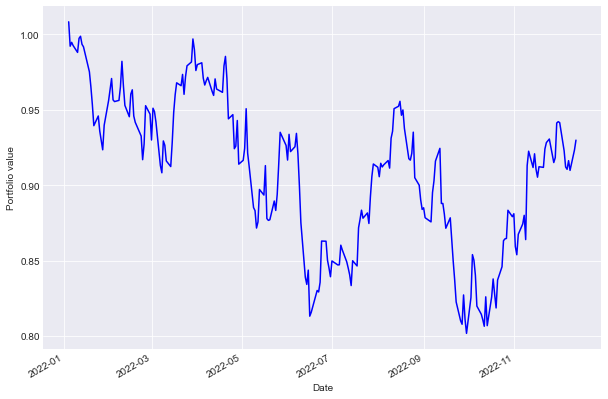

In [9]:

portfolio = pd.DataFrame()
portfolio['returns'] = stock_prices_pc.mean(axis=1)
portfolio['value'] = (portfolio+1).cumprod()
portfolio = portfolio.dropna()
portfolio.value.plot(color='b',figsize=(10,7))
plt.ylabel("Portfolio value")
plt.show()

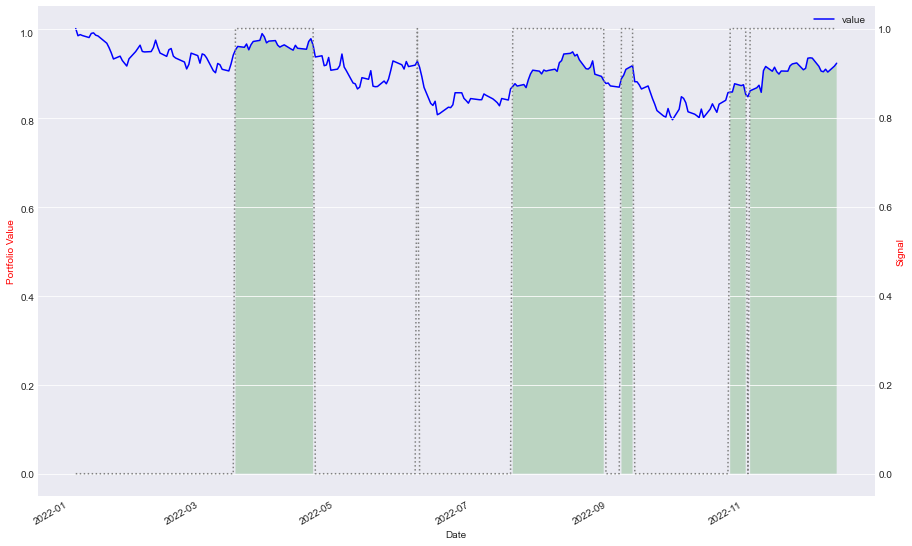

In [10]:
import numpy as np
def get_strategy_returns_sma(portfolio):
    # Calculate the simple moving average of period 10
    portfolio['sma10'] = portfolio.value.rolling(window=50).mean()
    # Create a trading signal
    portfolio['signal'] = np.where(portfolio.value > portfolio.sma10,1,0)
    # Calculate the strategy returns
    portfolio['str_returns'] = portfolio['returns'].shift(-1) * portfolio['signal']
    return portfolio

def plot_signal(portfolio):
    portfolio['value'].plot(color='blue')    
    plt.fill_between(portfolio.index, portfolio.value, where=(portfolio.signal==1), facecolor='g', alpha=0.2)      
    plt.legend()
    plt.ylabel('Portfolio Value',color='r')
    # Plot the signal values    
    portfolio['signal'].plot(secondary_y=True,figsize=(15,10),color='grey', linestyle='dotted')
    plt.ylabel('Signal',color='r')
    plt.show()

portfolio = get_strategy_returns_sma(portfolio)    
plot_signal(portfolio)  

The Sharpe ratio is 0.27 


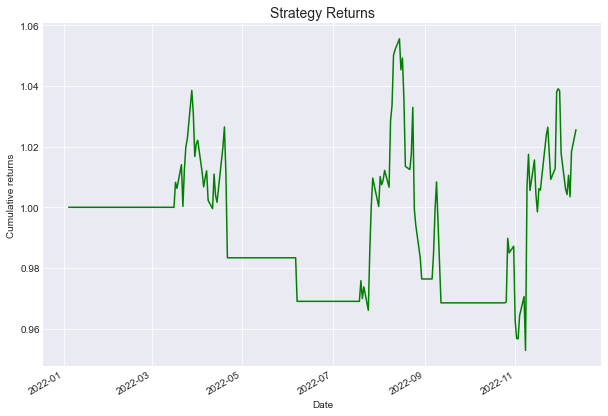

The maximum drawdown is -9.73


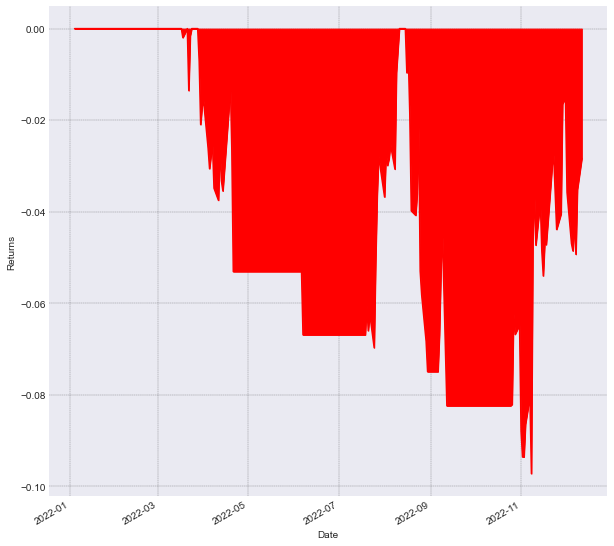

In [11]:
def plot_returns_dd(portfolio):
    # ----------- Sharpe ratio ------------------
    sharpe_ratio = np.mean(portfolio.str_returns)/np.std(portfolio.str_returns)*(252**0.5)
    print('The Sharpe ratio is %.2f ' % sharpe_ratio)

    # ----------- Cumulative strategy returns ------------------
    portfolio['cum_str_returns'] = (portfolio['str_returns']+1).cumprod()
    # Plot the cumulative strategy returns
    portfolio['cum_str_returns'].plot(figsize=(10,7), color='green')
    plt.title('Strategy Returns', fontsize=14)
    plt.ylabel('Cumulative returns')
    plt.show()        

    # ----------- Drawdown ------------------    
    # Calculate the running maximum
    running_max = np.maximum.accumulate(portfolio['cum_str_returns'].dropna())
    # Ensure the value never drops below 1
    running_max[running_max < 1] = 1
    # Calculate the percentage drawdown
    drawdown = (portfolio['cum_str_returns'])/running_max - 1
    max_dd = drawdown.min()*100
    print('The maximum drawdown is %.2f' % max_dd)
    # Plot the drawdowns
    drawdown.plot(color='r',figsize=(10,10))
    plt.ylabel('Returns')
    plt.fill_between(drawdown.index, drawdown, color='red')
    plt.grid(which="major", color='k', linestyle='-.', linewidth=0.2)
    plt.show()    
    
plot_returns_dd(portfolio)   

The Sharpe ratio is -0.55 


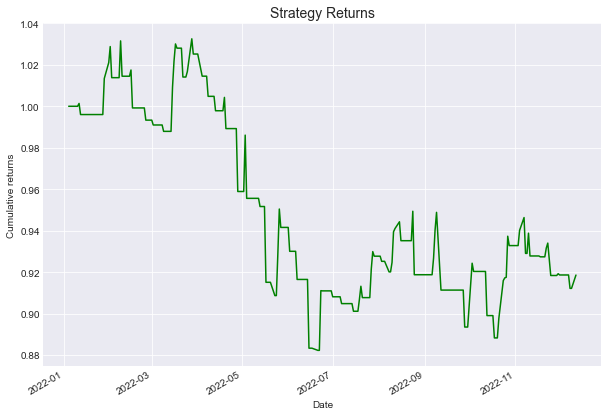

The maximum drawdown is -14.56


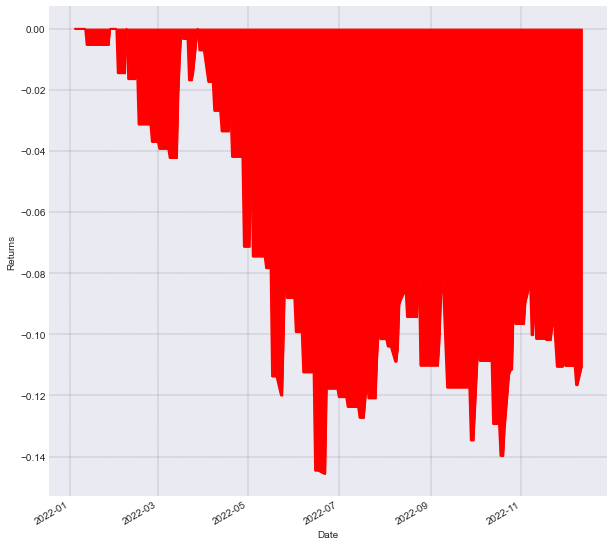

In [12]:
def get_strategy_returns_breakout(portfolio):
    # Calculate the breakout indicator values
    portfolio['high'] = portfolio.value.rolling(window=3).max()
    # Create a trading signal
    portfolio['signal'] = np.where(portfolio.value>=portfolio.high,1,0)
    # Calculate the strategy returns
    portfolio['str_returns'] = portfolio['returns'].shift(-1) * portfolio['signal']
    return portfolio

portfolio = get_strategy_returns_breakout(portfolio)
# plot_signal(portfolio)    
plot_returns_dd(portfolio)

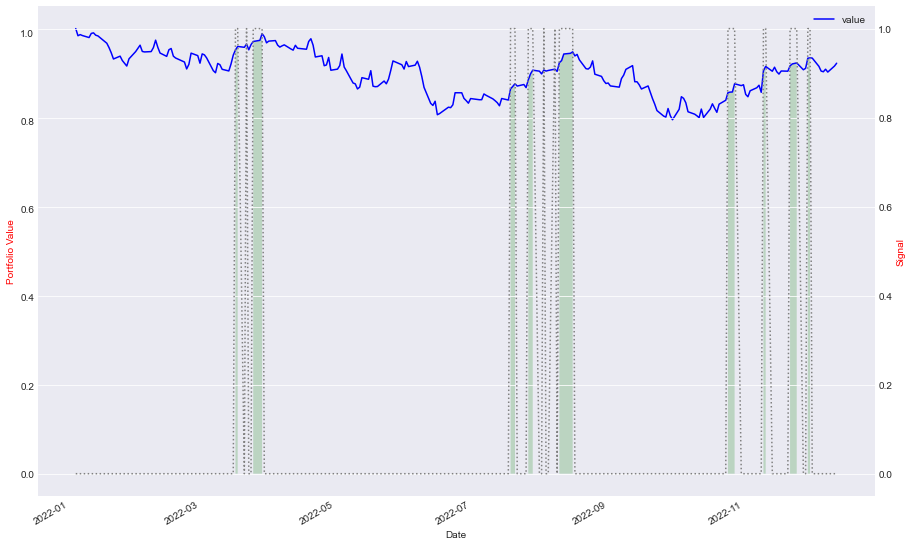

The Sharpe ratio is 1.02 


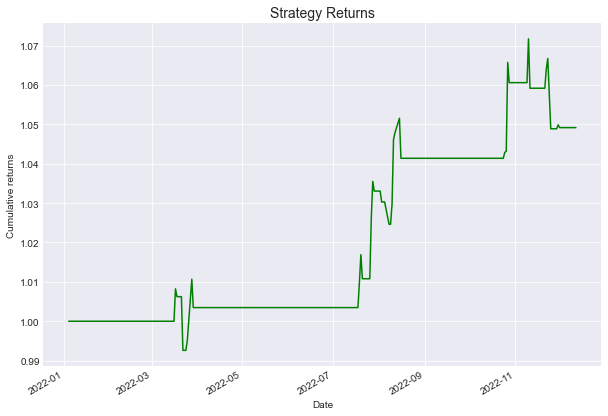

The maximum drawdown is -2.13


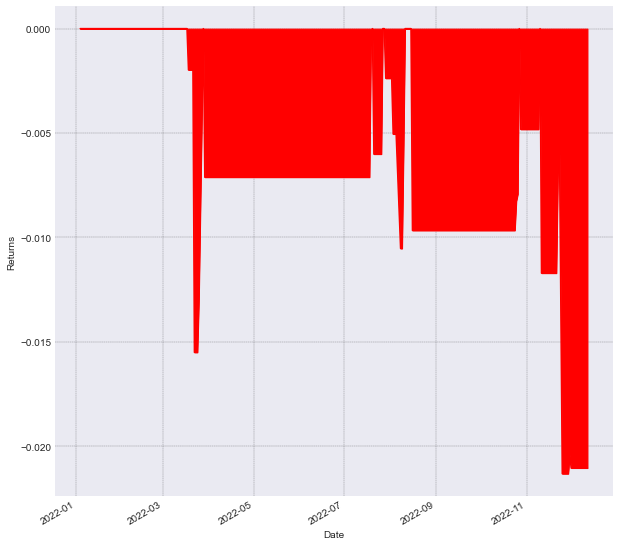

In [15]:

def get_strategy_returns_sma_breakout(portfolio):
    # Calculate the simple moving average 
    sma20 = portfolio.value > portfolio.value.rolling(window=20).mean()
    # Calculate the breakout indicator values
    breakout = portfolio.value>=portfolio.value.rolling(window=20).max()
   
    
    # Create a trading signal
    portfolio['signal'] = np.where(sma20 & breakout > 0.55 ,1,0)

    # Calculate the strategy returns
    portfolio['str_returns'] = portfolio['returns'].shift(-1) * portfolio['signal']
    return portfolio


def plot_signal(portfolio):
    portfolio['value'].plot(color='blue')    
    plt.fill_between(portfolio.index, portfolio.value, where=(portfolio.signal==1), facecolor='g', alpha=0.2)      
    plt.legend()
    plt.ylabel('Portfolio Value',color='r')
    # Plot the signal values    
    portfolio['signal'].plot(secondary_y=True,figsize=(15,10),color='grey', linestyle='dotted')
    plt.ylabel('Signal',color='r')
    plt.show()
    
portfolio = get_strategy_returns_sma_breakout(portfolio)
plot_signal(portfolio)    
plot_returns_dd(portfolio)
